<img src="../decaf.png" style="width: 30%"/>
<h2>DECAF: A Dynamically Extensible Corpus Analysis Framework</h2>
<strong>ACL 2025 (Demo Track)</strong>

In [1]:
from decaf.index import DecafIndex
from decaf.filters import Filter, Criterion, Condition

from helpers import *

## Import

<div style="text-align: center;">
<img src="rsrc/design-principles.png" style="width: 60%;"/>
</div>

In [2]:
DATA_PATH = '/path/to/ud-treebanks-v2.15/UD_English-GUM/en_gum-ud-dev.conllu'  # update to path on your local machine
INDEX_PATH = '/path/to/indices/en_gum-ud-dev'  # update to path on your local machine

In [ ]:
!python ../../scripts/import/ud.py --input {DATA_PATH} --output {INDEX_PATH} --force-alignment

## Corpus Analysis

In [5]:
decaf_index = DecafIndex(index_path=INDEX_PATH)
print(f"Loaded DECAF Index: {decaf_index}.")

Loaded DECAF Index: <DecafIndex: 'en_gum-ud-dev', 5 shard(s)>.


### Token Frequency

Total number of tokens: 23909
Most frequent tokens:


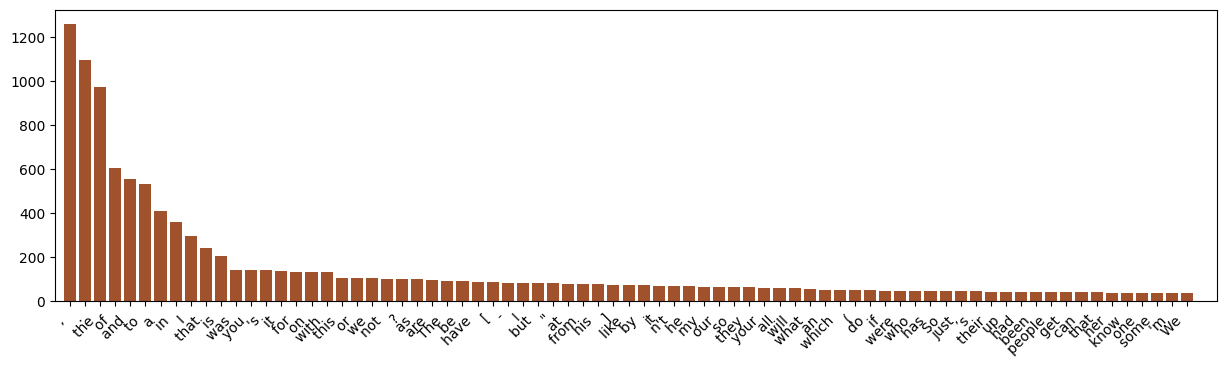

In [6]:
token_counts = decaf_index.get_structure_counts(types=['token'], literals=True)
print("Total number of tokens:", sum(c for c in token_counts.values()))

print("Most frequent tokens:")
structure_counts = {}
for rank, ((stype, literal), count) in enumerate(sorted(token_counts.items(), key=lambda i: i[1], reverse=True)[:75]):
	structure_counts[literal] = count

plot_frequency(structure_counts)

### Annotation Analysis


Completed retrieval of 401 match(es) from DECAF index in 0.02s.


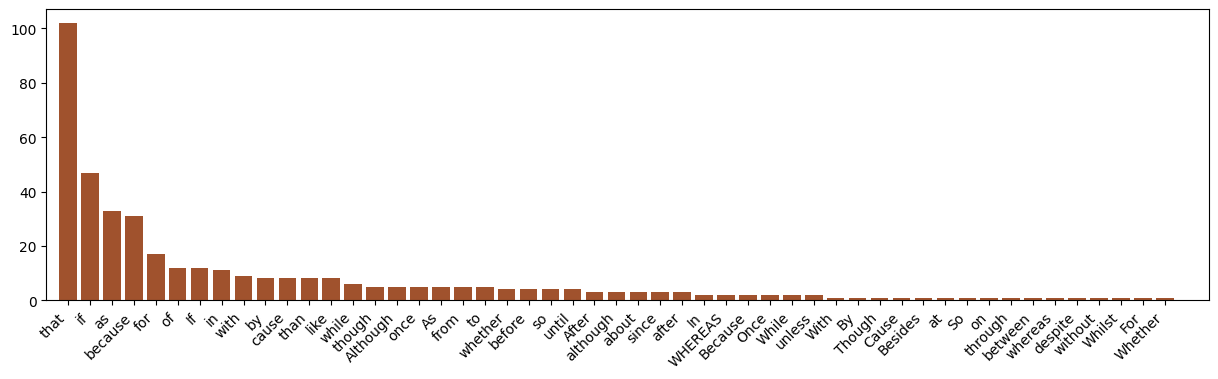

In [7]:
decaf_filter = Filter(
    criteria=[
	    Criterion(
		    conditions=[
			    Condition(stype='upos', values=['SCONJ']),
			    Condition(stype='deprel', values=['mark'])
		    ],
		    operation='AND'
	    )
    ],
)
structure_counts = count_filtered(decaf_index, decaf_filter)
plot_frequency(structure_counts)

### Co-occurrence Analysis

In [8]:
source_filter = Filter(
    criteria=[Criterion(conditions=[Condition(stype='meta::genre')])],
    hierarchy=['document']
)
target_filter = Filter(
    criteria=[Criterion(conditions=[Condition(stype='Gender')])],
    hierarchy=['document', 'sentence', 'token']
)

cooccurrence = decaf_index.get_cooccurence(
    source_constraint=source_filter,
    target_constraint=target_filter
)
display(cooccurrence)

targets,Gender=Fem,Gender=Masc,Gender=Neut
sources,,,
meta::genre=academic,0,0,9
meta::genre=bio,1,77,3
meta::genre=conversation,20,8,37
meta::genre=court,0,7,14
meta::genre=essay,1,1,17
meta::genre=fiction,4,58,18
meta::genre=interview,14,10,18
meta::genre=letter,5,6,6
meta::genre=news,25,11,8


## Filtering

<img src="rsrc/filtering.png" style="width: 100%;"/>

In the following, we reproduce the study from [Misra and Mahowald (2024)](https://aclanthology.org/2024.emnlp-main.53/), extracting all sentences containing AANN structures (e.g., "a beautiful five days") in ~0.2s:

In [9]:
decaf_filter = Filter(
    criteria=[
        Criterion(
	        operation='OR',
            conditions=[
                Condition(stype='upos', values=['DET'], literals=['a', 'an'])
            ]
        ),
        Criterion(
            conditions=[
                Condition(stype='upos', values=['ADJ'])
            ]
        ),
        Criterion(
            conditions=[
                Condition(stype='upos', values=['NUM'])
            ]
        ),
        Criterion(
            operation='AND',
            conditions=[
                Condition(stype='upos', values=['NOUN']),
                Condition(stype='Number', values=['Plur'])
            ]
        )
    ],
	sequential=True,
	hierarchy=['sentence', 'token']
)
structure_counts = count_filtered(decaf_index, decaf_filter, print_results=True)

[ID (1, 16511) | 34896-35100] 'A contemporary American may only walk a few dozen steps to the car, drive to work, ride the elevator to the office, walk a few dozen steps back to the car, get drive-thru food, then be back on the couch. '

Completed retrieval of 1 match(es) from DECAF index in 0.09s.


### Case Study: Relative Clauses
What if you really don't like relative clauses?

In [10]:
decaf_filter = Filter(
    criteria=[
        Criterion(
            conditions=[
                Condition(stype='dependency', values=['advcl%'], match='LIKE', min_count=2)
            ]
        )
    ],
	hierarchy=['sentence']
)
structure_counts = count_filtered(decaf_index, decaf_filter, print_results=True)

[ID (0, 6874) | 3382-3545] 'Although attrition may take place within the first few years, some studies suggest that it then appears to level off, with no further losses occurring [17], [18]. '
[ID (0, 9111) | 4629-4939] 'In 2015, an initiative was started to set up a Dutch speaking DH+Lib community in the Netherlands and Belgium, based on the example of the American communal space of librarians, archivists, LIS graduate students, and information specialists to discuss topics ‘Where the Digital Humanities and Libraries meet’. '
[ID (0, 12420) | 6681-7039] 'We are not setting out to turn them into programmers or data crunchers, but want to boost their knowledge level to where they feel comfortable providing information about DH projects, follow the literature and research, follow online tutorials and hopefully take up the challenge of finishing this professional development by engaging with the DH community. '
[ID (0, 14369) | 7871-8105] 'With these in hand, we will design the curriculum

In [11]:
masked_corpus = decaf_index.mask(constraint=decaf_filter, mask_level='substructures')
print(masked_corpus)
print("-"*32)
print(masked_corpus[masked_corpus.find("Memorized jokes sound wooden"):][:101], "...")
print("-"*32)
print("Total length:", len(masked_corpus))

Introduction Research on adult-learned second language (L2) has provided considerable insight into the neurocognitive mechanisms underlying the learning and processing of L2 grammar [1]–[11]. Of interest here, studies suggest that, despite the difficulties in acquiring L2 grammar, adult learners can approximate native-like levels of use and neurocognitive processing [12]–[15]. However, it is not enough to have attained such native-like levels. Crucially, it is also desirable to retain them, even in the absence of continued practice or exposure to the L2. In fact, substantial periods (months to years) of limited or no exposure following L2 training are not uncommon, and may even be the norm [16]. Such a scenario may be found in different situations, including when one studies a language in a classroom and then stops taking classes [17], [18] and when one is immersed in a foreign language setting and then moves away [19]. In the present study, we examine the outcomes of such a period of 

## Cross-index Analyses

<div style="text-align: center;">
<img src="rsrc/cross-index.png" style="width: 60%;"/>
</div>

DECAF facilitates analyses across datasets by allowing for the easy extraction of annotation statistics from across indices.

In [12]:
DECAF_INDICES = {
	'train': DecafIndex(index_path='/path/to/decaf/indices/en_gum-ud-train'),  # update to path on your local machine
	'dev': decaf_index,
	'test': DecafIndex(index_path='/path/to/decaf/indices/en_gum-ud-test')  # update to path on your local machine
}

RELEVANT_TYPES = [
	stype for stype in decaf_index.get_structure_counts()
	if stype not in {
		'document', 'paragraph', 'sentence', 'dependency', 'token',
		'document_id', 'paragraph_id', 'sent_id',
		'head', 'lemma', 'meta::title', 'meta::sourceURL', 'meta::dateCollected', 'meta::dateCreated', 'meta::dateModified', 'meta::author', 'meta::salientEntities', 'meta::summary', 'addressee', 'Bridge', 'CorrectForm', 'Cxn', 'CxnElt', 'Discourse', 'ExtPos', 'Entity', 'global.Entity', 'PDTB', 'MSeg', 'SpaceAfter', 'speaker', 'SplitAnte', 'XML'
	}
]
print(f"Comparing {len(RELEVANT_TYPES)} annotation layers:")
print(RELEVANT_TYPES)

Comparing 28 annotation layers:
['Abbr', 'Case', 'Definite', 'Degree', 'Gender', 'Mood', 'Negation', 'NumForm', 'NumType', 'Number', 'Person', 'Polarity', 'Poss', 'PronType', 'Reflex', 'Style', 'Tense', 'Typo', 'VerbForm', 'Voice', 'deprel', 'meta::genre', 'meta::speakerCount', 's_prominence', 's_type', 'transition', 'upos', 'xpos']


In [13]:
annotation_statistics = {}
for name, di in DECAF_INDICES.items():
	annotation_statistics[name] = di.get_structure_counts(types=RELEVANT_TYPES, values=True)
	print(f"{name:<5}: {len(annotation_statistics[name])} annotation-value pairs.")

train: 224 annotation-value pairs.
dev  : 218 annotation-value pairs.
test : 213 annotation-value pairs.


In [14]:
total_sizes = {split: di.get_structure_counts(types=['token'])['token'] for split, di in DECAF_INDICES.items()}
print(total_sizes)

{'train': 164020, 'dev': 23909, 'test': 23991}


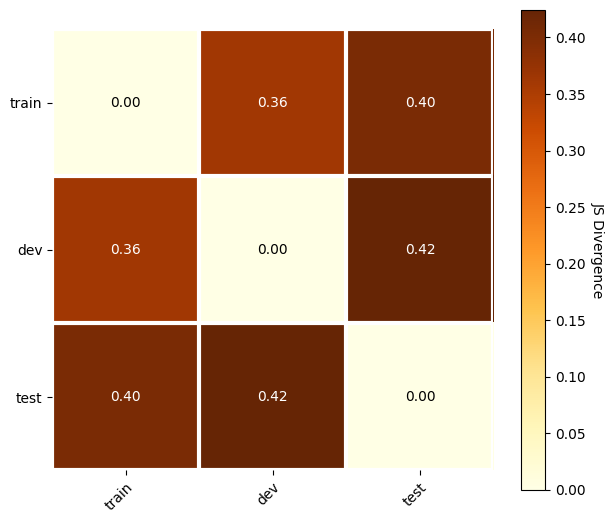

In [15]:
js_divergence, comparisons, statistics = compute_divergence(annotation_statistics, total_sizes)
plot_confusions(js_divergence, labels=['train', 'dev', 'test'])

## Reproducibility

<div style="text-align: center;">
<img src="rsrc/reproducibility.png" style="width: 60%;"/>
</div>

DECAF separates annotation indices and filters from the raw data, making it much easier to share pre-built indices, extend them with new annotation layers, and apply filters to new datasets.

In [16]:
!ls -lh ~/Documents/projects/decaf/indices/

total 0
drwxr-xr-x@ 7 mamy  staff   224B Mar 27 15:20 en_gum-ud-dev
drwxr-xr-x@ 3 mamy  staff    96B Mar 27 16:10 en_gum-ud-test
drwxr-xr-x@ 3 mamy  staff    96B Mar 27 16:12 en_gum-ud-train


# Thank You!

You can find DECAF at [https://mxij.me/x/decaf](https://mxij.me/x/decaf).